# Wavelet Learned Lossy Compression (WaLLoC)

WaLLoC sandwiches a convolutional autoencoder between time-frequency analysis and synthesis transforms using 
CDF 9/7 wavelet filters. The time-frequency transform increases the number of signal channels, but reduces the temporal or spatial resolution, resulting in lower GPU memory consumption and higher throughput. WaLLoC's training procedure is highly simplified compared to other $\beta$-VAEs, VQ-VAEs, and neural codecs, but still offers significant dimensionality reduction and compression. This makes it suitable for dataset storage and compressed-domain learning. It currently supports 1D and 2D signals (e.g. mono, stereo, or multi-channel audio, grayscale, RGB, or hyperspectral images).

## Installation

1. Follow the installation instructions for [torch](https://pytorch.org/get-started/locally/)
2. Install WaLLoC and other dependencies via pip

```pip install walloc PyWavelets pytorch-wavelets```

## Pre-trained checkpoints

Pre-trained checkpoints are available on [Hugging Face](https://huggingface.co/danjacobellis/walloc).

## Training

Access to training code is provided by request via [email.](mailto:danjacobellis@utexas.edu)

## Usage example

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor
from walloc import walloc
from walloc.walloc import latent_to_pil, pil_to_latent
class Config: pass

### Load the model from a pre-trained checkpoint

```wget https://hf.co/danjacobellis/walloc/resolve/main/v0.12.0.pth```

In [2]:
device = "cpu"
checkpoint = torch.load("v0.12.0.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec_config.n_bits=5
codec = walloc.Walloc(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

### Load an example image

```wget "https://r0k.us/graphics/kodak/kodak/kodim05.png"```

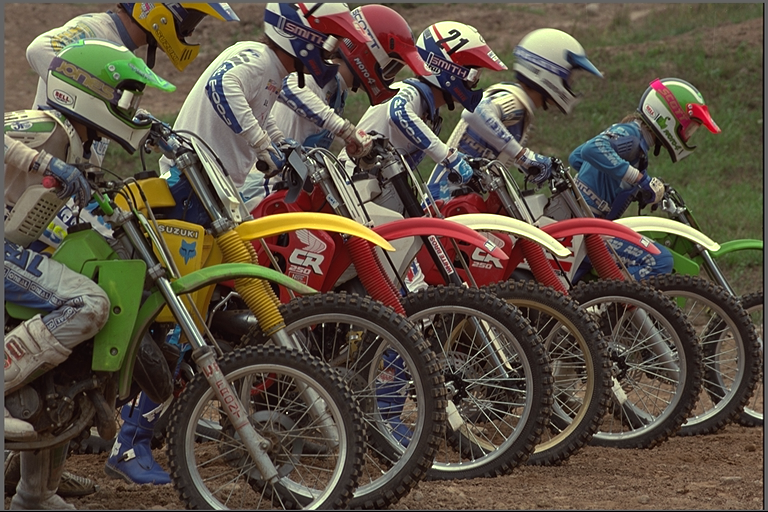

In [3]:
img = Image.open("kodim05.png")
img

### Full encoding and decoding pipeline with .forward()

* If `codec.eval()` is called, the latent is rounded to nearest integer.

* If `codec.train()` is called, uniform noise is added instead of rounding.

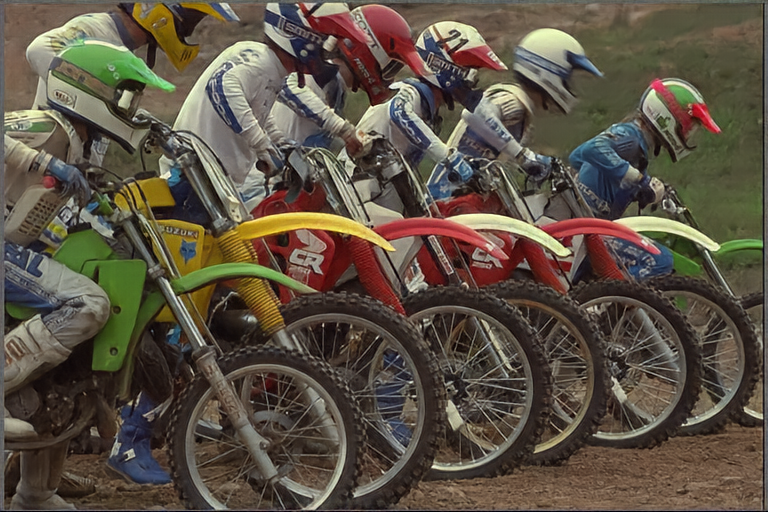

In [4]:
with torch.no_grad():
    codec.eval()
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    x_hat, _, _ = codec(x)
ToPILImage()(x_hat[0]+0.5)

### Accessing latents

In [5]:
with torch.no_grad():
    codec.eval()
    X = codec.wavelet_analysis(x,J=codec.J)
    Y = codec.encoder(X)
    X_hat = codec.decoder(Y)
    x_hat = codec.wavelet_synthesis(X_hat,J=codec.J)

print(f"dimensionality reduction: {x.numel()/Y.numel()}×")

dimensionality reduction: 7.68×


In [6]:
Y.unique()

tensor([-3., -2., -1., -0.,  1.,  2.,  3.])

(-3.5, 3.5)

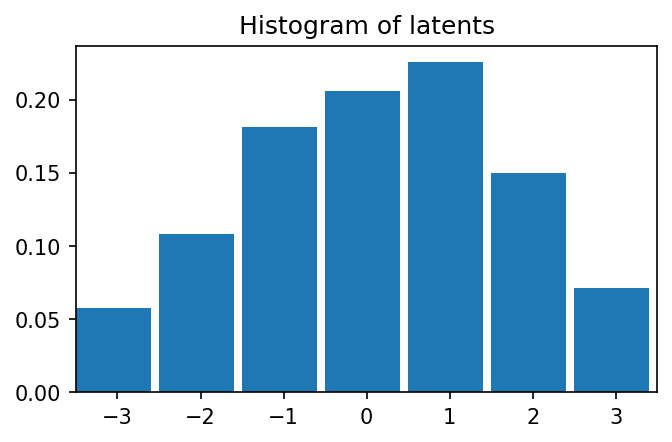

In [7]:
plt.figure(figsize=(5,3),dpi=150)
plt.hist(
    Y.flatten().numpy(),
    range=(-3.5,3.5),
    bins=7,
    density=True,
    width=0.9);
plt.title("Histogram of latents")
plt.xticks(range(-3,4,1));
plt.xlim([-3.5,3.5])

# Lossless compression of latents

In [8]:
from PIL import Image

def scale_for_display(img, n_bits):
    # Calculate the scale factor based on the bit depth
    scale_factor = (2**8 - 1) / (2**n_bits - 1)
    
    # Create a LUT for scaling the values based on the scale factor
    lut = [int(i * scale_factor) for i in range(2**n_bits)]
    
    # Split the image into individual channels (even for grayscale, this works uniformly)
    channels = img.split()
    
    # Apply the LUT to each channel
    scaled_channels = [ch.point(lut * 32) for ch in channels]
    
    # Merge the scaled channels back into the original mode (works for all modes)
    return Image.merge(img.mode, scaled_channels)

### Single channel PNG (L)

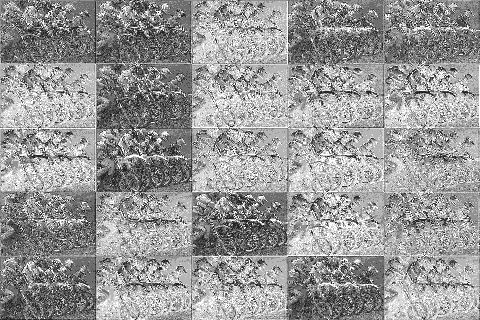

compression_ratio:  20.23965410747375


In [9]:
Y_pil = latent_to_pil(Y,codec.latent_bits,1)
lut = [i * 36 for i in range(8)]
display(scale_for_display(Y_pil[0], codec.latent_bits))
Y_pil[0].save('latent.png')
png = [Image.open("latent.png")]
Y_rec = pil_to_latent(png,codec.latent_dim,codec.latent_bits,1)
assert(Y_rec.equal(Y))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.png"))

### Three channel WebP (RGB)

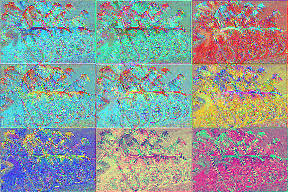

compression_ratio:  24.118748722142712


In [10]:
Y_padded = torch.nn.functional.pad(Y, (0, 0, 0, 0, 0, 2))
Y_pil = latent_to_pil(Y_padded,codec.latent_bits,3)
display(scale_for_display(Y_pil[0], codec.latent_bits))
Y_pil[0].save('latent.webp',lossless=True)
webp = [Image.open("latent.webp")]
Y_rec = pil_to_latent(webp,27,codec.latent_bits,3)
assert(Y_rec[:,:25].equal(Y))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.webp"))

### Four channel TIF (CMYK)

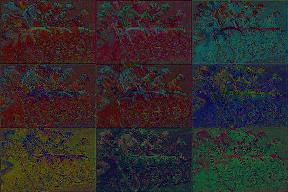

compression_ratio:  17.685877061469267


In [11]:
Y_padded = torch.nn.functional.pad(Y, (0, 0, 0, 0, 0, 11))
Y_pil = latent_to_pil(Y_padded,codec.latent_bits,4)
display(scale_for_display(Y_pil[0], codec.latent_bits))
Y_pil[0].save('latent.tif',compression="tiff_adobe_deflate")
tif = [Image.open("latent.tif")]
Y_rec = pil_to_latent(tif,36,codec.latent_bits,4)
assert(Y_rec[:,:25].equal(Y))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.tif"))

In [12]:
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 5002 bytes to README.md


In [13]:
!sed -i 's|!\[png](README_files/\(README_[0-9]*_[0-9]*\.png\))|![png](https://huggingface.co/danjacobellis/walloc/resolve/main/README_files/\1)|g' README.md